# Benchmark paper experiments 

This notebook contains the code for generating the pictures and graphs for the paper "Waterberry Farms: a realistic benchmark for multi-robot informative path planning"

In [1]:
# allow imports from the main source directory
import sys
sys.path.append('..')
import logging
logging.basicConfig(level=logging.WARNING)
# logging.basicConfig(level=logging.INFO)
#logging.getLogger().setLevel(logging.INFO)

import pathlib
import pickle
import bz2 as compress
import matplotlib.pyplot as plt
import matplotlib.lines as lines

from Environment import Environment, EpidemicSpreadEnvironment, DissipationModelEnvironment, PrecalculatedEnvironment
from InformationModel import StoredObservationIM, GaussianProcessScalarFieldIM, DiskEstimateScalarFieldIM, im_score, im_score_weighted
from Robot import Robot
from Policy import GoToLocationPolicy, FollowPathPolicy, RandomWaypointPolicy, \
    AbstractWaypointPolicy, InformationGreedyPolicy
from PathGenerators import generate_lawnmower
from WaterberryFarm import create_wbfe, WaterberryFarm, MiniberryFarm, WaterberryFarmInformationModel, waterberry_score, get_datadir
from WbfExperiment import menu

# Generate the picture for the Waterberry farms geometry. 

In [2]:
# A savedir that is not dependent on running stuff
#p = pathlib.Path(__file__).parent.resolve().parent.parent
#datadir = pathlib.Path(p.parent, "__Temporary", p.name + "_data")
#print(datadir)
# savedir.mkdir(parents=True, exist_ok = True)


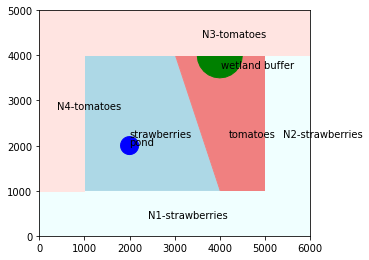

In [3]:
#results = menu({"geometry": 4})
benchmark_dir = pathlib.Path(get_datadir(), "BenchmarkPaper")
benchmark_dir.mkdir(parents=True, exist_ok = True)
geom = WaterberryFarm()
fig, ax = plt.subplots(1, figsize=(5,4))
geom.visualize(ax)
fig.tight_layout()
plt.savefig(pathlib.Path(benchmark_dir, "WBF_Layout.pdf"))


# Visualization of different environment at various time points
Note that this should use the pre-saved versions

INFO:root:loading the geometry and environment from saved data
INFO:root:loading done
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:Loading from bz2 /home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Miniberry-30/precalc_tylcv/env_value_00001.bz2
INFO:root:Loading from bz2 /home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Miniberry-30/precalc_tylcv/env_value_00001.bz2 done
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:Loading from bz2 /home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Miniberry-30/precalc_ccr/env_value_00001.bz2
INFO:root:Loading from bz2 /home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Miniberry-30/precalc_ccr/env_value_00001.bz2 done
INFO:root:Environment.proceed - calling the inner_proceed
INFO

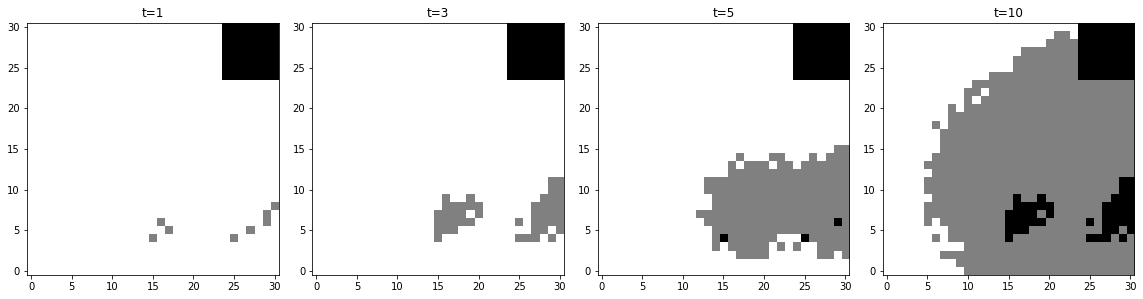

In [12]:
#timepoints = [0, 10, 20, 30]
timepoints = [1, 3, 5, 10]
# typename = "Miniberry-10"
typename = "Miniberry-30"
_, wbfe, _ = create_wbfe(saved = True, wbf_prec = None, typename = typename)
fig, axs = plt.subplots(1, len(timepoints), figsize = (4 * len(timepoints), 4))
ntt = 0
for t in range(timepoints[-1]+1):
    if t >= timepoints[ntt]:
        axs[ntt].imshow(wbfe.tylcv.value.T, vmin=0, vmax=1, cmap="gray", origin="lower")
        axs[ntt].set_title(f"t={timepoints[ntt]}")
        ntt = ntt + 1
    wbfe.proceed()
fig.tight_layout()
plt.savefig(pathlib.Path(benchmark_dir, f"{typename}-env-dynamics.pdf"))


In [5]:
axs

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

# Run an experiment and save the results
The results will be saved into `2022-01-15-MREM_data/Miniberry-10/res_pol#`

INFO:root:loading the geometry and environment from saved data
INFO:root:loading done
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 6
INFO:root:Loading from bz2 /home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Miniberry-10/precalc_tylcv/env_value_00006.bz2
INFO:root:Loading from bz2 /home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Miniberry-10/precalc_tylcv/env_value_00006.bz2 done
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 6
INFO:root:Loading from bz2 /home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Miniberry-10/precalc_ccr/env_value_00006.bz2
INFO:root:Loading from bz2 /home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Miniberry-10/precalc_ccr/env_value_00006.bz2 done
INFO:root:Environment.proceed - calling the inner_proceed
INFO

Choose the policy
	1. Lawnmower - full coverage by day
	2. Lawnmower - restart
	3. Random waypoint


INFO:root:Saving results to: /home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Miniberry-10/res-pol_3


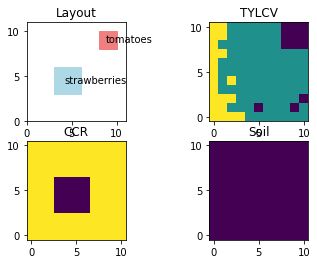

In [13]:
results = menu({"geometry": 1, "action": 4, "scenario": 1, "visualize": 0, "time_start_environment": 6})

Process the results of the experiment and generate a figure with the environment, information model and score. 

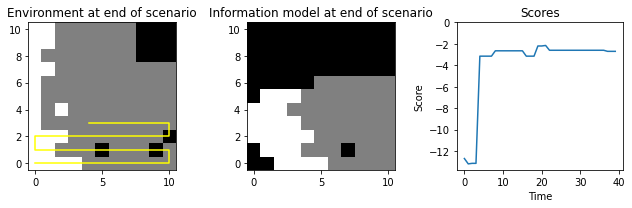

In [8]:
#print(results)
wbfe = results["wbfe"]
wbfim = results["wbfim"]
fig, ((ax_env_tylcv, ax_im_tylcv, ax_scores)) = plt.subplots(1, 3, figsize=(9,3))
# visualize the environment
image_env_tylcv = ax_env_tylcv.imshow(wbfe.tylcv.value.T, vmin=0, vmax=1, origin="lower", cmap="gray")
ax_env_tylcv.set_title("Environment at end of scenario")
# visualize the information model
image_im_tylcv = ax_im_tylcv.imshow(wbfim.im_tylcv.value.T, vmin=0, vmax=1, origin="lower", cmap="gray")
ax_im_tylcv.set_title("Information model at end of scenario")
# visualize the observations, which gives us the path of the robot
obsx = []
obsy = []
for obs in results["observations"]:
    obsx.append(obs[StoredObservationIM.X])
    obsy.append(obs[StoredObservationIM.Y])
    old_obs = obs
ax_env_tylcv.add_line(lines.Line2D(obsx, obsy, color="yellow"))
ax_scores.plot(results["scores"])
ax_scores.set_ylim(top=0)
ax_scores.set_xlabel("Time")
ax_scores.set_ylabel("Score")
ax_scores.set_title("Scores")
fig.tight_layout()
plt.savefig(pathlib.Path(results["savedir"], "Benchmark.pdf"))


In [6]:
results.keys()

dict_keys(['typename', 'time_start_environment', 'wbf', 'wbfe', 'scenario', 'days', 'values', 'robot', 'velocity', 'timespan', 'policy', 'oneshot', 'wbfim', 'score', 'scores', 'observations', 'positions'])

In [5]:
print(results["choices"])

{'geometry': 1, 'action': 4, 'scenario': 1, 'visualize': 0, 'time_start_environment': 6, 'policy': 1}


# Process all the experiments and generate a comparative graph of the evolution of the score.

In [2]:
# FIXME: this relies on getting the path from results, but it should be runnable even if we had not run an experiment
p = pathlib.Path(results["savedir"])
allresults = []
for a in p.iterdir():
    if a.name.startswith("res-"):
        with compress.open(a, "rb") as f:
            results = pickle.load(f)
            allresults.append(results)

NameError: name 'pathlib' is not defined

In [16]:
allresults

[{'choices': {'geometry': 1,
   'action': 4,
   'scenario': 1,
   'visualize': 0,
   'time_start_environment': 6,
   'policy': 2},
  'typename': 'Miniberry-10',
  'time_start_environment': 6,
  'wbf': <WaterberryFarm.MiniberryFarm at 0x7f1930bd8a90>,
  'wbfe': <WaterberryFarm.WaterberryFarmEnvironment at 0x7f1930b47a00>,
  'savedir': PosixPath('/home/lboloni/Documents/HackingWork/__Temporary/2022-01-15-MREM_data/Miniberry-10'),
  'scenario': 1,
  'days': 1,
  'values': 'single',
  'robot': <Robot.Robot at 0x7f19309a8400>,
  'velocity': 1,
  'timespan': 40.0,
  'policy': 'lawnmower-restart',
  'oneshot': False,
  'wbfim': <WaterberryFarm.WaterberryFarmInformationModel at 0x7f19309b42e0>,
  'score': -1.7000000000000002,
  'scores': [-12.7,
   -13.2,
   -13.15,
   -13.15,
   -3.15,
   -3.15,
   -3.15,
   -3.15,
   -2.6500000000000004,
   -2.6500000000000004,
   -2.6500000000000004,
   -2.6500000000000004,
   -2.6500000000000004,
   -2.6500000000000004,
   -2.6500000000000004,
   -2.650000

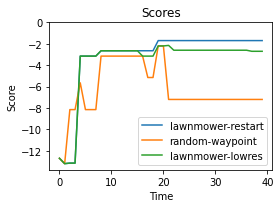

In [27]:
fig, ax_scores = plt.subplots(1, figsize=(4,3))
for results in allresults:
    ax_scores.plot(results["scores"], label = results["policy"])
ax_scores.set_ylim(top=0)
ax_scores.set_xlabel("Time")
ax_scores.set_ylabel("Score")
ax_scores.set_title("Scores")
ax_scores.legend()
fig.tight_layout()
